In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
!pip install feature_engine

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
from feature_engine.encoding import WoEEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 2.6 MB/s eta 0:00:00


In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
month_dict = {
   "01": 1,
   "02": 2,
   "03": 3,
   "04": 4,
   "05": 5,
   "06": 6,
   "07": 7,
   "08": 8,
   "09": 9,
   "10": 10,
   "11": 11,
   "12": 12
}

def get_expires_values(df):
  _df = df["expires"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["expires_month"] = _df["month"].astype(str)
  df["expires_years"] = _df["years"].astype(int)
  return df

def get_acct_open_date_values(df):
  _df = df["acct_open_date"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["acct_open_date_month"] = _df["month"].astype(str)
  df["acct_open_date_years"] = _df["years"].astype(int)
  return df


card = get_expires_values(card)
card = get_acct_open_date_values(card)
card["expires_month"] = card["expires_month"].map(month_dict)
card["acct_open_date_month"] = card["acct_open_date_month"].map(month_dict)

card["dt_acct_open_date"] = pd.to_datetime(card["acct_open_date"])
card["dt_expires"] = pd.to_datetime(card["expires"])

tmps = []
card["index"] = 1
for id in list(card.user_id.unique()):
  tmp = card.loc[card["user_id"]==id].sort_values("dt_acct_open_date")
  tmp["have_card"] = tmp["index"].cumsum()  # x枚目のカード
  tmps.append(tmp[["user_id", "card_id", "have_card"]])
card_h = pd.concat(tmps)
card = card.merge(card_h, how="left", on=["user_id", "card_id"])

In [7]:
card["credit_limit"] = card["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
user["per_capita_income_zipcode"] = user["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
user["yearly_income_person"] = user["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
user["total_debt"] = user["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [8]:
use_limit = card.groupby("user_id")["credit_limit"].sum().to_dict()
card["credit_limit_sum"] = card["user_id"].map(use_limit)

In [9]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [10]:
concat_data = pd.concat([train,test],axis=0)
concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

concat_data = concat_data.fillna("NAN")

In [11]:
# 買った町と住んでいる町が一致していれば1
concat_data["merchant_address_city"] = 0
concat_data.loc[concat_data["merchant_city"]==concat_data["city"], "merchant_address_city"] = 1

# オンライン１　現地0
concat_data["is_ONLINE"] = 0
concat_data.loc[concat_data["merchant_city"]=="ONLINE", "is_ONLINE"] = 1

# 家の住所と購買距離
lat_state_mean = concat_data.groupby("state")["latitude"].mean().to_dict()
lon_state_mean = concat_data.groupby("state")["longitude"].mean().to_dict()
lat_mean = concat_data["latitude"].mean()
lon_mean = concat_data["longitude"].mean()
concat_data["merchant_lat"] = concat_data["merchant_state"].map(lat_state_mean)
concat_data["merchant_lon"] = concat_data["merchant_state"].map(lon_state_mean)
concat_data["merchant_lat"] = concat_data["merchant_lat"].fillna(lat_mean)
concat_data["merchant_lon"] = concat_data["merchant_lon"].fillna(lon_mean)
concat_data["merchant_address_distance"] = np.sqrt((concat_data["latitude"]-concat_data["merchant_lat"])**2 + (concat_data["longitude"]-concat_data["merchant_lon"])**2)

In [12]:
city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

In [13]:
for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [14]:
income_mean = concat_data["yearly_income_person"].mean()
concat_data["income_all_rate"] = concat_data["yearly_income_person"] / income_mean  # 平均年収の稼いでいる割合
concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]  # 市町村の平均年収の何倍その人が稼いでいるか
concat_data["debt_rate"] = concat_data["total_debt"] / concat_data["yearly_income_person"]  # ローン総額の年収に対する割合
concat_data["limit_rate"] = concat_data["credit_limit_sum"] / concat_data["yearly_income_person"]  # 利用上限総額に対する年収の割合
concat_data["amount_rate"] = concat_data["amount"] / concat_data["credit_limit"]   # 買い物した額の上限額の割合
concat_data["diff_retire_age"] = concat_data["retirement_age"] - concat_data["current_age"]  # 退職してからの年数
concat_data["period_use_card"] = (concat_data["expires_years"] - concat_data["acct_open_date_years"])*12 + (concat_data["expires_month"] - concat_data["acct_open_date_month"])  # カード使用期間(月)
concat_data["diff_expirs_change_pin"] = concat_data["expires_years"] - concat_data["year_pin_last_changed"]  # pinコードを最後に変更した日から有効期限までの年数
concat_data["diff_change_pin_acct_open"] = concat_data["year_pin_last_changed"] - concat_data["acct_open_date_years"] # アカウント作成日からpinコードを最後に変更した日までの年数
concat_data["acct_oppen_age"] = (concat_data["acct_open_date_years"] - concat_data["birth_year"])*12 + (concat_data["acct_open_date_month"] - concat_data["birth_month"])  # アカウント作成時の年齢(月)

# コンペ開始時期でも使えるカードか否か
concat_data["current_use_card"] = 0
concat_data.loc[concat_data["expires_years"]>=2024, "current_use_card"] = 1
concat_data.loc[((concat_data["expires_years"]>=2023) & (concat_data["expires_month"]>=8)), "current_use_card"] = 1


In [15]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [16]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
ori_categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [17]:
amount_user_mean = concat_data.groupby("user_id")["amount"].mean().to_dict()
train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [18]:
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in ori_categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))

user_id
card_id
errors?
merchant_id
merchant_city


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


merchant_state
mcc
use_chip
card_brand
card_type
has_chip
gender
city
state
birth_month


In [19]:
train_df[target] = train_df[target].astype(float)
corr_list = [target] + numerical_features + [f"{col}_woe" for col in ori_categorical_features if col not in "merchant_id"]
train_df[corr_list].corr()

,is_fraud?,amount,cards_issued,credit_limit,current_age,retirement_age,birth_year,latitude,longitude,per_capita_income_zipcode,...,merchant_state_woe,mcc_woe,use_chip_woe,card_brand_woe,card_type_woe,has_chip_woe,gender_woe,city_woe,state_woe,birth_month_woe
is_fraud?,1.000000,0.149597,-0.007397,-0.025715,-0.012937,-0.017675,0.013430,0.011108,0.002455,-0.019102,...,0.295577,0.215924,0.225278,0.030054,0.024515,0.023347,0.017183,0.091221,0.042386,0.046113
amount,0.149597,1.000000,-0.037866,0.084524,0.023139,-0.030107,-0.023042,-0.002821,-0.041324,0.154798,...,0.096415,0.114324,0.083184,0.010130,0.001320,0.012968,-0.019735,-0.022535,-0.056414,-0.050840
cards_issued,-0.007397,-0.037866,1.000000,-0.064020,-0.044524,-0.018097,0.043976,0.060634,-0.023949,-0.005225,...,-0.021674,-0.011799,-0.017527,-0.072797,0.013158,0.015306,-0.075932,0.013628,-0.021174,0.029326
credit_limit,-0.025715,0.084524,-0.064020,1.000000,-0.080352,0.006515,0.080956,0.092856,-0.073889,0.440021,...,0.025703,0.006251,0.006417,-0.141868,-0.459051,-0.034776,0.015439,-0.032624,0.044000,-0.055505
current_age,-0.012937,0.023139,-0.044524,-0.080352,1.000000,0.019487,-0.999726,-0.124155,0.031799,-0.008372,...,0.022004,0.009978,-0.000593,-0.099158,0.057243,-0.020377,-0.044322,-0.149934,-0.120522,0.034517
retirement_age,-0.017675,-0.030107,-0.018097,0.006515,0.019487,1.000000,-0.021244,0.061564,0.079153,-0.119159,...,-0.037914,-0.006190,0.008893,-0.023159,-0.025785,-0.031450,-0.019119,-0.177096,-0.034974,0.007626
birth_year,0.013430,-0.023042,0.043976,0.080956,-0.999726,-0.021244,1.000000,0.124970,-0.029487,0.005640,...,-0.020390,-0.010031,0.001345,0.100585,-0.058511,0.019226,0.044416,0.152521,0.124589,-0.025175
latitude,0.011108,-0.002821,0.060634,0.092856,-0.124155,0.061564,0.124970,1.000000,0.038502,0.078695,...,0.073812,-0.013868,-0.008528,-0.021290,-0.076998,-0.052635,0.127250,0.133762,0.269481,0.069878
longitude,0.002455,-0.041324,-0.023949,-0.073889,0.031799,0.079153,-0.029487,0.038502,1.000000,-0.228946,...,-0.004897,-0.030780,-0.003158,0.057189,-0.054855,0.053170,-0.024717,0.024449,0.048816,0.006158
per_capita_income_zipcode,-0.019102,0.154798,-0.005225,0.440021,-0.008372,-0.119159,0.005640,0.078695,-0.228946,1.000000,...,0.028039,0.027478,0.014517,-0.073518,-0.061816,-0.039089,-0.026715,-0.140201,-0.074656,-0.188863


In [20]:
class CFG:
  debug=False
  ver=74
  model="et"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target

In [21]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [22]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [23]:
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [24]:
features = numerical_features + ori_categorical_features + [f"{col}_woe" for col in ori_categorical_features if col not in "merchant_id"]  + ["amount_mean", "diff_amount"] \
+ ["debt_rate", "limit_rate","income_rate", "diff_retire_age", "period_use_card", "diff_expirs_change_pin", "diff_change_pin_acct_open", "acct_oppen_age",
 "merchant_address_distance", "credit_limit_sum", "have_card", "acct_open_date_years", "expires_years"] + \
  ["current_use_card", "merchant_address_city","expires_month", "acct_open_date_month", "is_ONLINE", "income_all_rate", "city_c", "state_c"]
categorical_features = ori_categorical_features +  ["current_use_card", "merchant_address_city","expires_month", "acct_open_date_month"]
oof_df = pd.DataFrame()
test_preds = []

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_df[features]
    train_labels = train_folds[CFG.target]
    valid_labels = valid_folds[CFG.target]

    train_X = train_X.replace([np.inf, -np.inf], -1)
    valid_X = valid_X.replace([np.inf, -np.inf], -1)
    test_X = test_X.replace([np.inf, -np.inf], -1)

    #train_w0, train_w1 = calc_log_loss_weight(train_labels)


    model = ExtraTreesClassifier(max_depth=5, random_state=CFG.seed, n_estimators=600)
    model.fit(train_X, train_labels)

    valid_folds["pred"] = model.predict_proba(valid_X)[:, 1]
    test_pred = model.predict_proba(test_X)[:, 1]
    test_preds.append(test_pred)
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    scoreacc = accuracy_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")

===============  FOLD : 0  ===============
F1 Score : 0.0015309246785058174
===============  FOLD : 1  ===============
F1 Score : 0.003670285976448998
===============  FOLD : 2  ===============
F1 Score : 0.0
===============  FOLD : 3  ===============
F1 Score : 0.0
===============  FOLD : 4  ===============
F1 Score : 0.0012251148545176112


In [25]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.0012862130213756354


In [26]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.951, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.3549392712550607
F1 score at threshold 0.16 is 0.36003115330372365
F1 score at threshold 0.17 is 0.36521644194552105
F1 score at threshold 0.18 is 0.3717148283352098
F1 score at threshold 0.19 is 0.38820273351296647
F1 score at threshold 0.2 is 0.41179537845106756
F1 score at threshold 0.21 is 0.42165260208039773
F1 score at threshold 0.22 is 0.42011634319463464
F1 score at threshold 0.23 is 0.4063741915374425
F1 score at threshold 0.24 is 0.3844288290529196
F1 score at threshold 0.25 is 0.35579206614477965
F1 score at threshold 0.26 is 0.32321366732078954
F1 score at threshold 0.27 is 0.2896844543085979
F1 score at threshold 0.28 is 0.2570136650928077
F1 score at threshold 0.29 is 0.2256622302623078
F1 score at threshold 0.3 is 0.18692142088266955
F1 score at threshold 0.31 is 0.148740972086668
F1 score at threshold 0.32 is 0.11567697319540492
F1 score at threshold 0.33 is 0.09017704003023344
F1 score at threshold 0.34 is 0.07406537252944113
F1 score at

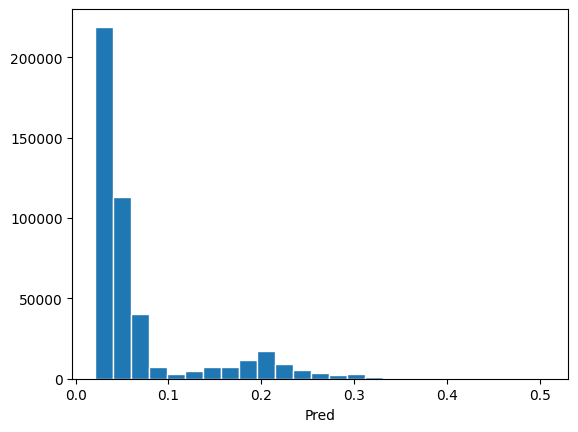

,index,is_fraud?
0,471283,0
1,471284,0
2,471285,0
3,471286,0
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    427685
1     30273
Name: is_fraud?, dtype: int64

In [27]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
submit.columns = ["index","pred"]
pred = np.mean(test_preds, axis=0)
submit['pred'] = pred
submit[CFG.target] = (pred>best_thresh).astype(int)
submit[f"pred0{CFG.ver}_fold0"] = test_preds[0]
submit[f"pred0{CFG.ver}_fold1"] = test_preds[1]
submit[f"pred0{CFG.ver}_fold2"] = test_preds[2]
submit[f"pred0{CFG.ver}_fold3"] = test_preds[3]
submit[f"pred0{CFG.ver}_fold4"] = test_preds[4]


submit[["index","is_fraud?"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)


plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit[["index","is_fraud?"]])
display(submit[CFG.target].value_counts())

In [28]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

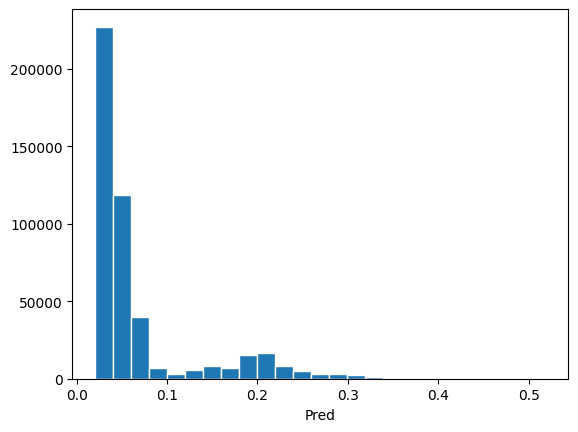

In [29]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [30]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)


submit.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False)
display(submit.head())

,index,pred,is_fraud?,pred074_fold0,pred074_fold1,pred074_fold2,pred074_fold3,pred074_fold4
0,471283,0.038412,0,0.038943,0.038310,0.038216,0.038425,0.038168
1,471284,0.045443,0,0.045242,0.047744,0.044856,0.045123,0.044251
2,471285,0.054390,0,0.054258,0.054230,0.053696,0.054089,0.055676
3,471286,0.099147,0,0.101593,0.096778,0.095058,0.100770,0.101536
4,471287,0.030452,0,0.030555,0.030618,0.030548,0.030257,0.030284
